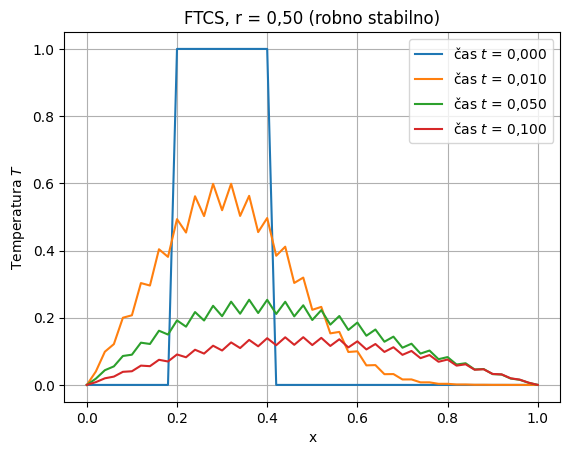

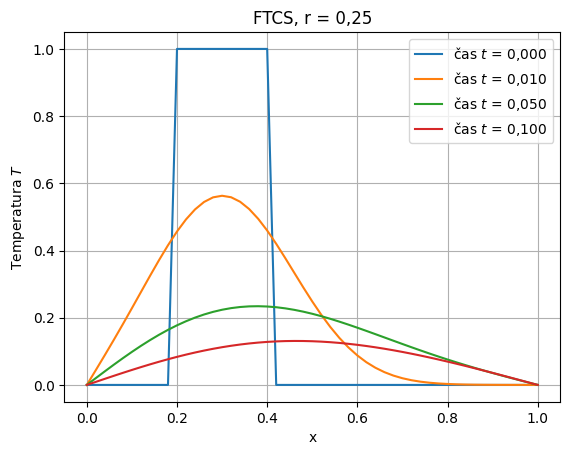

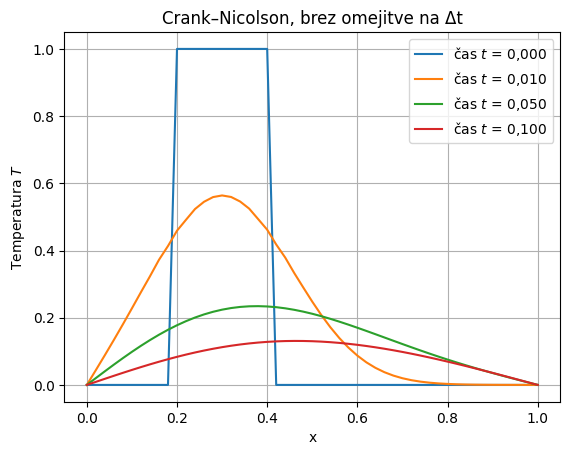

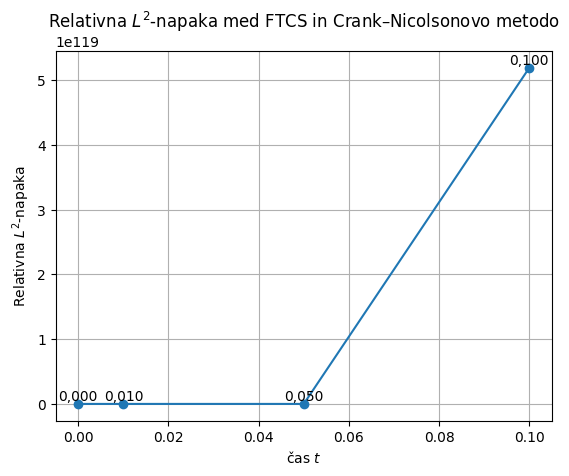

In [7]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def initial_condition(x, a, T0):
    T = np.zeros_like(x)
    mask = (x >= 0.2 * a) & (x <= 0.4 * a)
    T[mask] = T0
    return T

def ftcs(D, a, Nx, dt, T0, t_max, record_times):
    dx = a / Nx
    x = np.linspace(0, a, Nx + 1)
    r = D * dt / dx**2
    u = initial_condition(x, a, T0)
    sol = {0.0: u.copy()}
    u_new = u.copy()
    Nt = int(np.ceil(t_max / dt))
    time = 0.0
    for n in range(1, Nt + 1):
        u_new[1:-1] = u[1:-1] + r * (u[2:] - 2*u[1:-1] + u[:-2])
        u_new[0] = 0; u_new[-1] = 0  
        u, u_new = u_new, u
        time += dt
        if np.any(np.isclose(time, record_times, atol=1e-8)):
            sol[round(time, 8)] = u.copy()
    return x, sol

def crank_nicolson(D, a, Nx, dt, T0, t_max, record_times):
    dx = a / Nx
    x = np.linspace(0, a, Nx + 1)
    r = D * dt / dx**2
    N_int = Nx - 1
    
    A = sp.diags([(-r/2)*np.ones(N_int-1), (1 + r)*np.ones(N_int), (-r/2)*np.ones(N_int-1)], [-1,0,1], format='csr')
    B = sp.diags([( r/2)*np.ones(N_int-1), (1 - r)*np.ones(N_int), ( r/2)*np.ones(N_int-1)], [-1,0,1], format='csr')
    u = initial_condition(x, a, T0)
    sol = {0.0: u.copy()}
    Nt = int(np.ceil(t_max / dt))
    time = 0.0
    for n in range(1, Nt + 1):
        b = B.dot(u[1:-1])
        b[0]  += (r/2)* (u[0]  + 0)
        b[-1] += (r/2)* (u[-1] + 0)
        u_int = spla.spsolve(A, b)
        u[1:-1] = u_int
        u[0] = 0; u[-1] = 0
        time += dt
        if np.any(np.isclose(time, record_times, atol=1e-8)):
            sol[round(time, 8)] = u.copy()
    return x, sol


D = 1.0
a = 1.0
T0 = 1.0
t_max = 0.1
record_times = [0.0, 0.01, 0.05, 0.1]

experiments = [
    ("FTCS", 0.5*(a/50)**2/D, "r = 0,50 (robno stabilno)"),
    ("FTCS", 0.25*(a/50)**2/D, "r = 0,25"),
    ("Crank–Nicolson", 1e-3, "brez omejitve na Δt")
]

for method, dt, label in experiments:
    if method == "FTCS":
        x, sol = ftcs(D, a, 50, dt, T0, t_max, record_times)
    else:
        x, sol = crank_nicolson(D, a, 50, dt, T0, t_max, record_times)
    
    plt.figure()
    for t, u in sol.items():
        t_str = f"{t:.3f}".replace('.',',')
        plt.plot(x, u, label=f"čas $t$ = {t_str}")
    plt.title(f"{method}, {label}")
    plt.xlabel("x")
    plt.ylabel("Temperatura $T$")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{method}_{label.replace(' ', '_').replace(',', '')}.png", dpi=300)
    plt.show()

dt_common = 0.0005
x, sol_ftcs = ftcs(D, a, 50, dt_common, T0, t_max, record_times)
x, sol_cn   = crank_nicolson(D, a, 50, dt_common, T0, t_max, record_times)
errors = []
for t in record_times:
    u_f = sol_ftcs[round(t, 8)]
    u_c = sol_cn[round(t, 8)]
    err = np.linalg.norm(u_f - u_c) / np.linalg.norm(u_c)
    errors.append(err)
plt.figure()

times_str = [f"{t:.3f}".replace('.',',') for t in record_times]
plt.plot(record_times, errors, marker='o')
for rt, err, lab in zip(record_times, errors, times_str):
    plt.text(rt, err, lab, ha='center', va='bottom')
plt.title("Relativna $L^2$-napaka med FTCS in Crank–Nicolsonovo metodo")
plt.xlabel("čas $t$")
plt.ylabel("Relativna $L^2$-napaka")
plt.grid(True)
plt.savefig("error_plot.png", dpi=300)
plt.show()


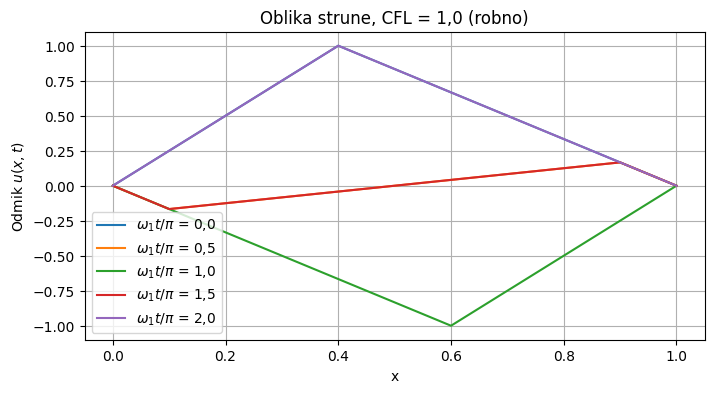

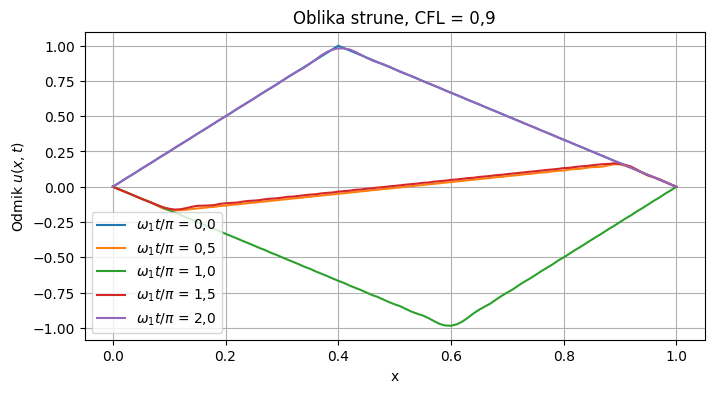

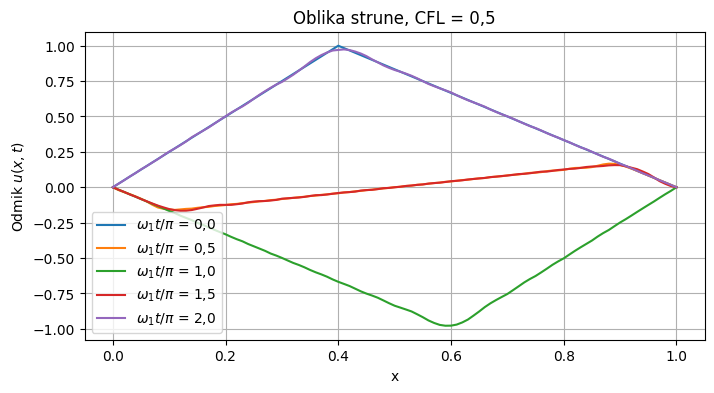

In [10]:
c = 1.0
a = 1.0 
Nx = 100
dx = a / Nx
x = np.linspace(0, a, Nx + 1)

taus = [0.0, 0.5, 1.0, 1.5, 2.0]

peak = 0.4 * a
f = np.where(x <= peak,
             x / peak,
             (a - x) / (a - peak))

g = np.zeros_like(x)

def solve_wave(c, dx, dt, taus, f):
    CFL = c * dt / dx
    t_max = max(taus) * a / c
    Nt = int(np.ceil(t_max / dt))
    
    record_steps = {int(round((tau * a / c) / dt)): tau for tau in taus}
    sol = {}
    
    sol[0.0] = f.copy()
    
    u_prev = f.copy()
    u_curr = f.copy()
    u_curr[1:-1] += 0.5 * CFL**2 * (f[2:] - 2*f[1:-1] + f[:-2])
    if 1 in record_steps:
        sol[record_steps[1]] = u_curr.copy()
    
    for n in range(1, Nt):
        u_next = 2*u_curr - u_prev
        u_next[1:-1] += CFL**2 * (u_curr[2:] - 2*u_curr[1:-1] + u_curr[:-2])
        u_next[0] = 0
        u_next[-1] = 0
        
        step = n + 1
        if step in record_steps:
            sol[record_steps[step]] = u_next.copy()
        
        u_prev, u_curr = u_curr, u_next
    
    return sol

experiments = [
    ("CFL = 1,0 (robno)", dx / c),
    ("CFL = 0,9", 0.9 * dx / c),
    ("CFL = 0,5", 0.5 * dx / c)
]

for label, dt in experiments:
    sol = solve_wave(c, dx, dt, taus, f)
    plt.figure(figsize=(8, 4))
    for tau in taus:
        u = sol[tau]
        tau_str = f"{tau:.1f}".replace('.',',')
        plt.plot(x, u, label=f"$\omega_1 t/\\pi$ = {tau_str}")
    
    plt.title(f"Oblika strune, {label}")
    plt.xlabel("x")
    plt.ylabel("Odmik $u(x,t)$")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"wave_{label.replace(' ', '_')}.png", dpi=300)
    plt.show()



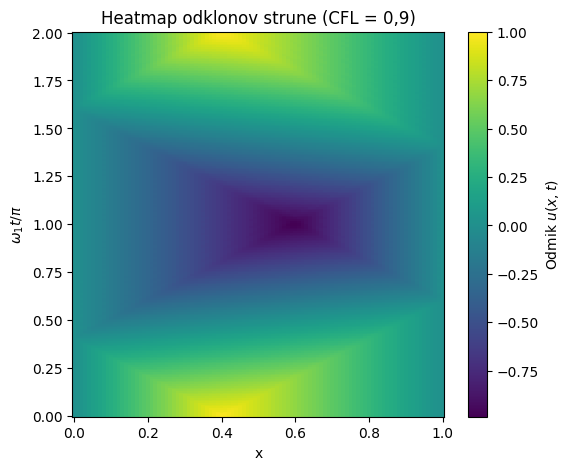

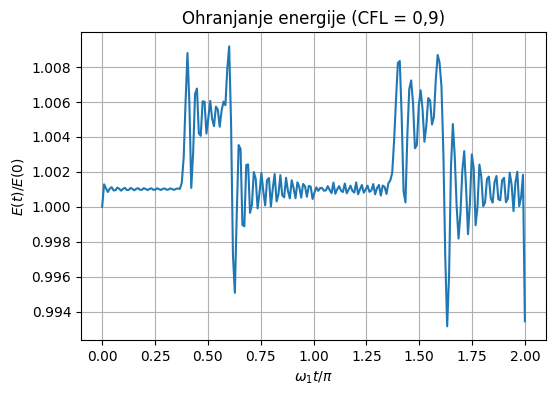

In [9]:
peak = 0.4 * a
f = np.where(x <= peak,
             x / peak,
             (a - x) / (a - peak))

def solve_wave_full(c, dx, dt, f):
    CFL = c * dt / dx
    t_max = 2.0 * a / c
    Nt = int(np.ceil(t_max / dt))
    
    u_prev = f.copy()
    u_curr = f.copy()
    u_curr[1:-1] += 0.5 * CFL**2 * (f[2:] - 2*f[1:-1] + f[:-2])
    
    U = np.zeros((Nt+1, Nx+1))
    U[0, :] = u_prev
    U[1, :] = u_curr
    times = np.linspace(0, t_max, Nt+1)
    
    for n in range(1, Nt):
        u_next = 2*u_curr - u_prev
        u_next[1:-1] += CFL**2 * (u_curr[2:] - 2*u_curr[1:-1] + u_curr[:-2])
        u_next[0] = 0
        u_next[-1] = 0
        
        U[n+1, :] = u_next
        u_prev, u_curr = u_curr, u_next
    
    return U, times

dt = 0.9 * dx / c
U, times = solve_wave_full(c, dx, dt, f)

plt.figure(figsize=(6,5))
plt.pcolormesh(x, times * c / a, U, shading='auto')
plt.colorbar(label='Odmik $u(x,t)$')
plt.xlabel('x')
plt.ylabel(r'$\omega_1 t/\pi$')
plt.title('Heatmap odklonov strune (CFL = 0,9)')
plt.savefig('wave_heatmap.png', dpi=300)
plt.show()

V = np.zeros_like(U)
V[1:-1] = (U[2:] - U[:-2]) / (2*dt)

UX = np.zeros_like(U)
UX[:,1:-1] = (U[:,2:] - U[:,:-2]) / (2*dx)

energy = 0.5 * np.sum(V**2 + c**2 * UX**2, axis=1) * dx
energy_ratio = energy / energy[0]

plt.figure(figsize=(6,4))
plt.plot(times * c / a, energy_ratio)
plt.xlabel(r'$\omega_1 t/\pi$')
plt.ylabel(r'$E(t)/E(0)$')
plt.title('Ohranjanje energije (CFL = 0,9)')
plt.grid(True)
plt.savefig('energy_conservation.png', dpi=300)
plt.show()
